In [40]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np

df = pl.read_csv("./DSU-Dataset.csv")
col = df["Date"].str.to_date()
df = df.with_columns(col)

df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,date,f64,str,i64,i64
"""A""",2018-01-01,0.0,"""BREATHING PROBLEM""",1,1
"""A""",2018-01-01,0.0,"""BURN""",1,0
"""A""",2018-01-01,0.0,"""SHAKING""",1,1
"""A""",2018-01-01,0.0,"""VOMITING""",1,0
"""A""",2018-01-01,1.0,"""FROSTBITE""",1,0


In [41]:
block_ranges = { 1: range(0, 6),
                 2: range(6, 12),
                 3: range(12, 18),
                 4: range(18, 24) }

min_date = df["Date"].min()
max_date = df["Date"].max()
begin_covid_date = df.filter(pl.col("Date").dt.year() == 2020).select(pl.col("Date")).min()
end_covid_date = df.filter(pl.col("Date").dt.year() == 2021).select(pl.col("Date")).max()


hourly_blocks_df = df.with_columns(
    pl.col("Hour").map_elements(lambda hr: next(block for block, hrs in block_ranges.items() if hr in hrs)).alias("Hour")
)
hourly_blocks_df = hourly_blocks_df.group_by(["Site", "Date", "Hour"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
hourly_blocks_df = hourly_blocks_df.sort(["Site", "Date", "Hour"])
hourly_blocks_df = hourly_blocks_df.with_columns(
    [
        pl.col("Date").dt.year().alias("Year"),
        pl.col("Date").dt.month().alias("Month"),
        pl.col("Date").dt.day().alias("Day"),
        pl.col("Date").dt.weekday().alias("Weekday"),
    ]
).drop("Date").select(["Site", "Year", "Month", "Day", "Weekday", "Hour", "ED Enc", "ED Enc Admitted"])

hourly_blocks_covid_df = hourly_blocks_df

# remove covid data
hourly_blocks_df = hourly_blocks_df.filter(pl.col("Year") != 2020).filter(pl.col("Year") != 2021)

hourly_blocks_df.head()

Site,Year,Month,Day,Weekday,Hour,ED Enc,ED Enc Admitted
str,i32,i8,i8,i8,i64,i64,i64
"""A""",2018,1,1,1,1,16,6
"""A""",2018,1,1,1,2,25,8
"""A""",2018,1,1,1,3,52,16
"""A""",2018,1,1,1,4,36,10
"""A""",2018,1,2,2,1,18,5


# Site A Random Forest Model

In [42]:
siteA_train = hourly_blocks_df.filter(pl.col("Site") == "A")
siteA_X = siteA_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteA_Y = siteA_train.select(["ED Enc", "ED Enc Admitted"])
siteA_X_train, siteA_X_test, siteA_Y_train, siteA_Y_test = train_test_split(siteA_X, siteA_Y, test_size=0.2, random_state=42)
siteA_model = RandomForestRegressor().fit(siteA_X_train, siteA_Y_train)

In [43]:
print(f"R² score of {siteA_model.score(siteA_X_test, siteA_Y_test)}")

R² score of 0.6319487731786142


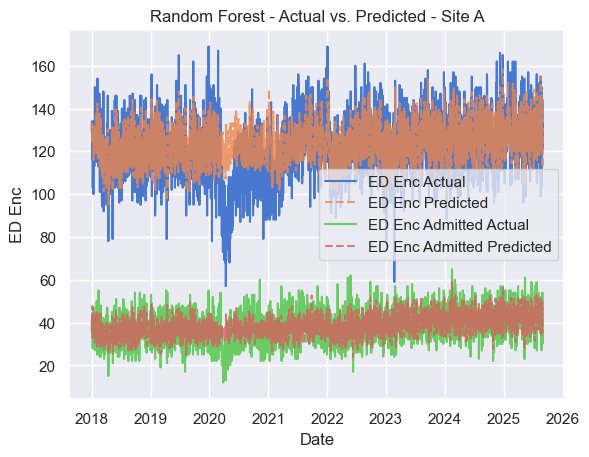

In [44]:
sns.set_theme(style="darkgrid", palette="muted")
siteA_real = hourly_blocks_covid_df.filter(pl.col("Site") == "A")
siteA_real_X = siteA_real.select(["Year", "Month", "Day", "Weekday", "Hour"])
    
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_model.predict(siteA_real_X)
predict_df = siteA_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)
ax.set_title("Random Forest - Actual vs. Predicted - Site A")

plt.show()

# Site B Random Forest Model

In [45]:
siteB_train = hourly_blocks_df.filter(pl.col("Site") == "B")
siteB_X = siteB_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteB_Y = siteB_train.select(["ED Enc", "ED Enc Admitted"])
siteB_X_train, siteB_X_test, siteB_Y_train, siteB_Y_test = train_test_split(siteB_X, siteB_Y, test_size=0.2, random_state=42)
siteB_model = RandomForestRegressor().fit(siteB_X_train, siteB_Y_train)

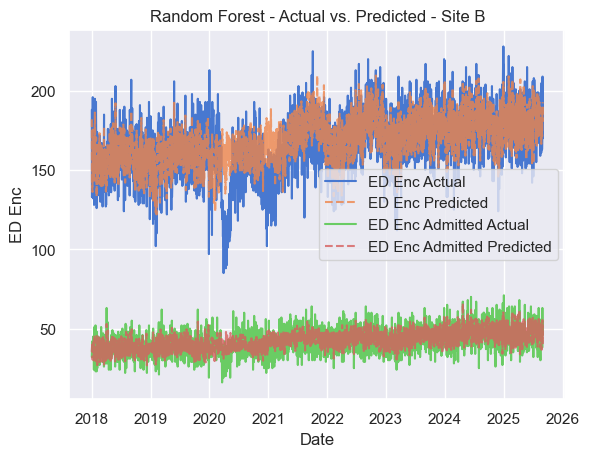

In [46]:
siteB_real = hourly_blocks_covid_df.filter(pl.col("Site") == "B")
siteB_real_X = siteB_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_model.predict(siteB_real_X)
predict_df = siteB_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random Forest - Actual vs. Predicted - Site B")
plt.show()

In [47]:
print(f"R² score of {siteB_model.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.642543079996225


# Site C Random Forest Model

In [48]:
siteC_train = hourly_blocks_df.filter(pl.col("Site") == "C")
siteC_X = siteC_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteC_Y = siteC_train.select(["ED Enc", "ED Enc Admitted"])
siteC_X_train, siteC_X_test, siteC_Y_train, siteC_Y_test = train_test_split(siteC_X, siteC_Y, test_size=0.2, random_state=42)
siteC_model = RandomForestRegressor().fit(siteC_X_train, siteC_Y_train)

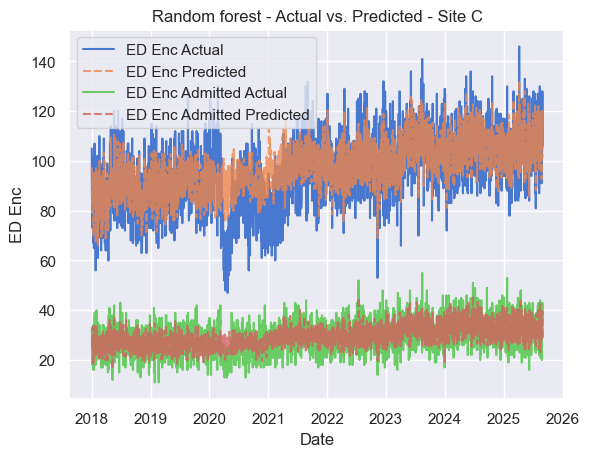

In [49]:
siteC_real = hourly_blocks_covid_df.filter(pl.col("Site") == "C")
siteC_real_X = siteC_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_model.predict(siteC_real_X)
predict_df = siteC_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random forest - Actual vs. Predicted - Site C")
plt.show()

In [50]:
print(f"R² score of {siteC_model.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.6109223850181649


# Site D Random Forest Model

In [51]:
siteD_train = hourly_blocks_df.filter(pl.col("Site") == "D")
siteD_X = siteD_train.select(["Year", "Month", "Day", "Weekday", "Hour"])
siteD_Y = siteD_train.select(["ED Enc", "ED Enc Admitted"])
siteD_X_train, siteD_X_test, siteD_Y_train, siteD_Y_test = train_test_split(siteD_X, siteD_Y, test_size=0.2, random_state=42)
siteD_model = RandomForestRegressor().fit(siteD_X_train, siteD_Y_train)

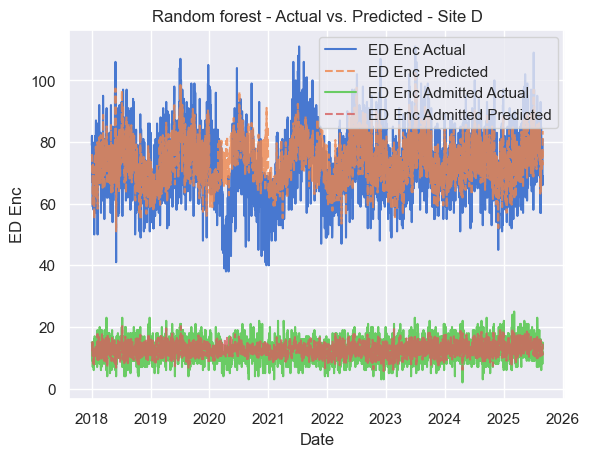

In [52]:
siteD_real = hourly_blocks_covid_df.filter(pl.col("Site") == "D")
siteD_real_X = siteD_real.select(["Year", "Month", "Day", "Weekday", "Hour"])

plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_model.predict(siteD_real_X)
predict_df = siteD_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Random forest - Actual vs. Predicted - Site D")
plt.show()

In [53]:
print(f"R² score of {siteD_model.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.47161985368843123


# Linear regression?
We can see from the EDA that, if we take out the COVID data, the data fits pretty closely to a line for each site.

## Site A 

In [54]:
from sklearn.linear_model import LinearRegression, Ridge

siteA_linreg = Ridge(alpha=1).fit(siteA_X_train, siteA_Y_train)
score = siteA_linreg.score(siteA_X_test, siteA_Y_test)
print(f"Ridge Regression R² score of {score}")

Ridge Regression R² score of 0.44831178406277755


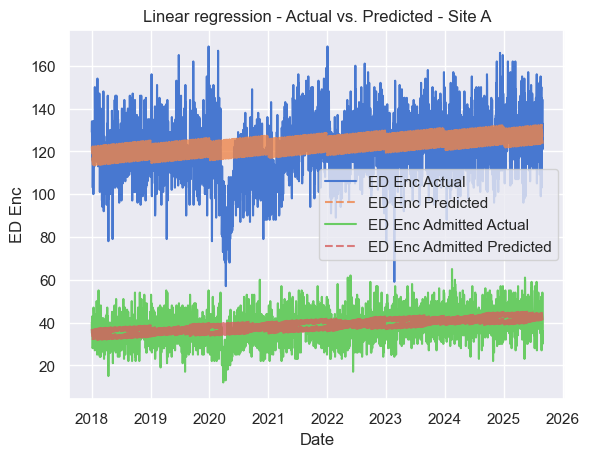

In [55]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_linreg.predict(siteA_real_X)
predict_df = siteA_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site A")
plt.show()

## Site B

In [56]:
siteB_linreg = Ridge().fit(siteB_X_train, siteB_Y_train)
print(f"R² score of {siteB_linreg.score(siteB_X_test, siteB_Y_test)}")

R² score of 0.5246460075832098


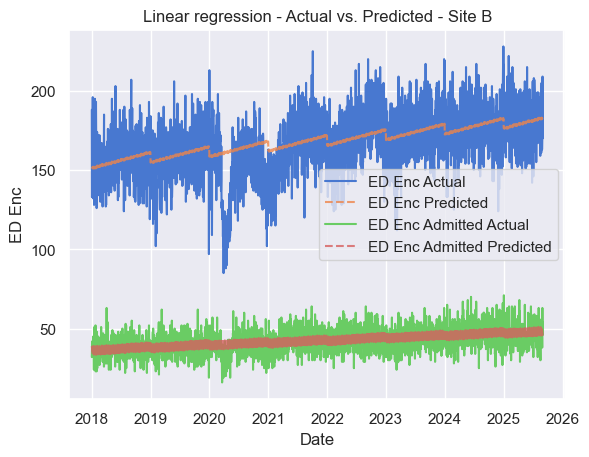

In [57]:
plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_linreg.predict(siteB_real_X)
predict_df = siteB_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site B")
plt.show()

## Site C

In [58]:
siteC_linreg = LinearRegression().fit(siteC_X_train, siteC_Y_train)
print(f"R² score of {siteC_linreg.score(siteC_X_test, siteC_Y_test)}")

R² score of 0.41803995754888046


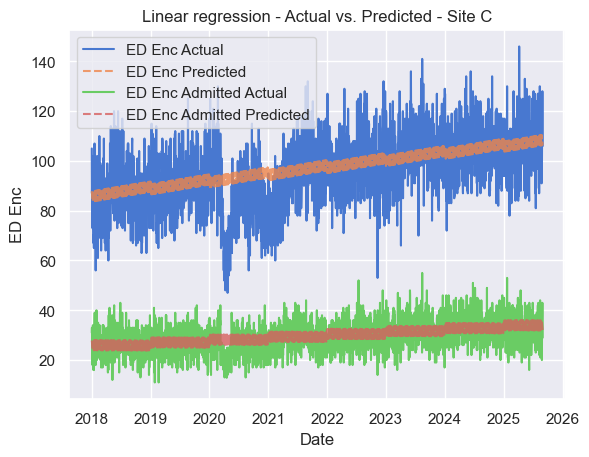

In [59]:
plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_linreg.predict(siteC_real_X)
predict_df = siteC_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site C")
plt.show()

## Site D

In [60]:
siteD_linreg = LinearRegression().fit(siteD_X_train, siteD_Y_train)
print(f"R² score of {siteD_linreg.score(siteD_X_test, siteD_Y_test)}")

R² score of 0.2842632788124216


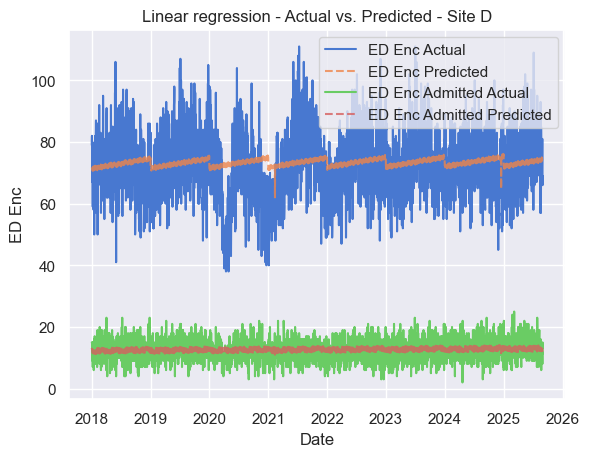

In [61]:
plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_linreg.predict(siteD_real_X)
predict_df = siteD_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("Linear regression - Actual vs. Predicted - Site D")
plt.show()

# CATboost?
Gradient boosted trees

In [62]:
from catboost import CatBoostRegressor, Pool
siteA_train_pool = Pool(siteA_X_train.to_pandas(), siteA_Y_train.to_pandas(), cat_features=siteA_X.columns)
siteA_test_pool = Pool(siteA_X_test.to_pandas(), siteA_Y_test.to_pandas(), cat_features=siteA_X.columns)

siteA_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteA_catmodel.fit(siteA_train_pool)

print(f"R² score of {siteA_catmodel.score(siteA_test_pool)}")

0:	learn: 12.3217568	total: 181ms	remaining: 3m 1s
1:	learn: 11.5069669	total: 217ms	remaining: 1m 48s
2:	learn: 10.8028442	total: 262ms	remaining: 1m 27s
3:	learn: 10.1875970	total: 310ms	remaining: 1m 17s
4:	learn: 9.6871008	total: 375ms	remaining: 1m 14s
5:	learn: 9.2332199	total: 431ms	remaining: 1m 11s
6:	learn: 8.8530527	total: 464ms	remaining: 1m 5s
7:	learn: 8.5200892	total: 508ms	remaining: 1m 3s
8:	learn: 8.2409481	total: 556ms	remaining: 1m 1s
9:	learn: 8.0111158	total: 598ms	remaining: 59.2s
10:	learn: 7.8321473	total: 626ms	remaining: 56.3s
11:	learn: 7.6738652	total: 693ms	remaining: 57s
12:	learn: 7.5337393	total: 738ms	remaining: 56s
13:	learn: 7.4100242	total: 783ms	remaining: 55.2s
14:	learn: 7.3041924	total: 838ms	remaining: 55s
15:	learn: 7.2310551	total: 869ms	remaining: 53.5s
16:	learn: 7.1737082	total: 890ms	remaining: 51.5s
17:	learn: 7.1070677	total: 939ms	remaining: 51.2s
18:	learn: 7.0674360	total: 975ms	remaining: 50.3s
19:	learn: 7.0169831	total: 1.06s	rema

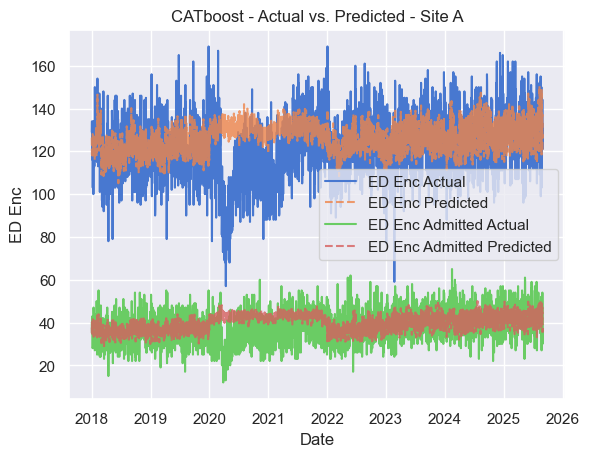

In [63]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteA_catmodel.predict(siteA_real_X.to_pandas())
predict_df = siteA_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site A")
plt.show()

In [64]:
siteB_train_pool = Pool(siteB_X_train.to_pandas(), siteB_Y_train.to_pandas(), cat_features=siteB_X.columns)
siteB_test_pool = Pool(siteB_X_test.to_pandas(), siteB_Y_test.to_pandas(), cat_features=siteB_X.columns)

siteB_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteB_catmodel.fit(siteB_train_pool)

print(f"R² score of {siteB_catmodel.score(siteB_test_pool)}")

0:	learn: 15.4809831	total: 53.8ms	remaining: 53.8s
1:	learn: 14.4170943	total: 102ms	remaining: 50.7s
2:	learn: 13.4987138	total: 133ms	remaining: 44.1s
3:	learn: 12.6557389	total: 188ms	remaining: 46.9s
4:	learn: 11.9461534	total: 244ms	remaining: 48.6s
5:	learn: 11.3604888	total: 284ms	remaining: 47.1s
6:	learn: 10.8682259	total: 318ms	remaining: 45.1s
7:	learn: 10.4256845	total: 351ms	remaining: 43.5s
8:	learn: 10.0420305	total: 423ms	remaining: 46.5s
9:	learn: 9.7211800	total: 475ms	remaining: 47.1s
10:	learn: 9.4183142	total: 556ms	remaining: 50s
11:	learn: 9.1685981	total: 628ms	remaining: 51.7s
12:	learn: 8.9545818	total: 689ms	remaining: 52.3s
13:	learn: 8.8076488	total: 727ms	remaining: 51.2s
14:	learn: 8.6479039	total: 795ms	remaining: 52.2s
15:	learn: 8.5404792	total: 837ms	remaining: 51.5s
16:	learn: 8.4373648	total: 888ms	remaining: 51.3s
17:	learn: 8.3560449	total: 947ms	remaining: 51.6s
18:	learn: 8.2778084	total: 1.03s	remaining: 53.3s
19:	learn: 8.2127563	total: 1.09s

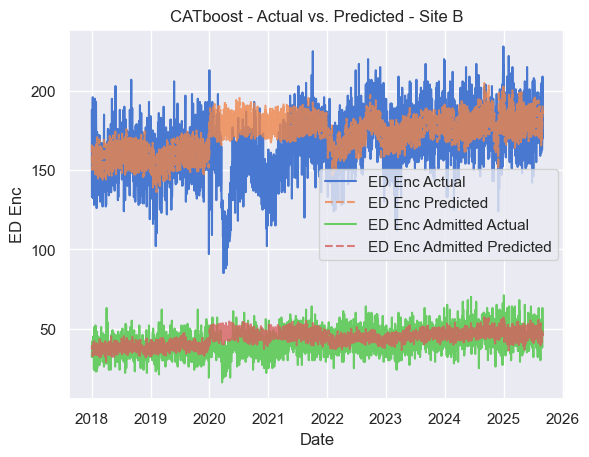

In [65]:
plot_df = siteB_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteB_catmodel.predict(siteB_real_X.to_pandas())
predict_df = siteB_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site B")
plt.show()

In [66]:
siteC_train_pool = Pool(siteC_X_train.to_pandas(), siteC_Y_train.to_pandas(), cat_features=siteC_X.columns)
siteC_test_pool = Pool(siteC_X_test.to_pandas(), siteC_Y_test.to_pandas(), cat_features=siteC_X.columns)

siteC_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteC_catmodel.fit(siteC_train_pool)

print(f"R² score of {siteC_catmodel.score(siteC_test_pool)}")

0:	learn: 10.4947379	total: 41.3ms	remaining: 41.2s
1:	learn: 9.8139953	total: 84.4ms	remaining: 42.1s
2:	learn: 9.2248420	total: 124ms	remaining: 41.1s
3:	learn: 8.7211428	total: 169ms	remaining: 42s
4:	learn: 8.2909703	total: 247ms	remaining: 49.1s
5:	learn: 7.9232963	total: 353ms	remaining: 58.4s
6:	learn: 7.6250773	total: 418ms	remaining: 59.4s
7:	learn: 7.3728040	total: 473ms	remaining: 58.7s
8:	learn: 7.1416281	total: 516ms	remaining: 56.8s
9:	learn: 6.9550874	total: 558ms	remaining: 55.3s
10:	learn: 6.7845702	total: 605ms	remaining: 54.4s
11:	learn: 6.6377921	total: 649ms	remaining: 53.5s
12:	learn: 6.5282548	total: 742ms	remaining: 56.4s
13:	learn: 6.4244403	total: 808ms	remaining: 56.9s
14:	learn: 6.3470597	total: 851ms	remaining: 55.9s
15:	learn: 6.2786226	total: 932ms	remaining: 57.3s
16:	learn: 6.2174559	total: 983ms	remaining: 56.8s
17:	learn: 6.1652399	total: 1.04s	remaining: 56.6s
18:	learn: 6.1172725	total: 1.09s	remaining: 56.2s
19:	learn: 6.0861578	total: 1.14s	remain

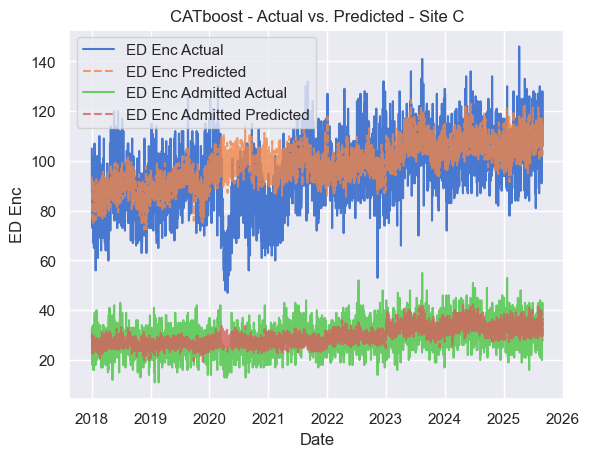

In [67]:
plot_df = siteC_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteC_catmodel.predict(siteC_real_X.to_pandas())
predict_df = siteC_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site C")
plt.show()

In [68]:
siteD_train_pool = Pool(siteD_X_train.to_pandas(), siteD_Y_train.to_pandas(), cat_features=siteD_X.columns)
siteD_test_pool = Pool(siteD_X_test.to_pandas(), siteD_Y_test.to_pandas(), cat_features=siteD_X.columns)

siteD_catmodel = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function="MultiRMSE")
siteD_catmodel.fit(siteD_train_pool)

print(f"R² score of {siteD_catmodel.score(siteD_test_pool)}")

0:	learn: 8.1849157	total: 51.1ms	remaining: 51s
1:	learn: 7.6883789	total: 86.4ms	remaining: 43.1s
2:	learn: 7.2609076	total: 130ms	remaining: 43.2s
3:	learn: 6.8953230	total: 175ms	remaining: 43.6s
4:	learn: 6.5845220	total: 213ms	remaining: 42.5s
5:	learn: 6.3212328	total: 248ms	remaining: 41.1s
6:	learn: 6.1096913	total: 275ms	remaining: 39s
7:	learn: 5.9202003	total: 323ms	remaining: 40.1s
8:	learn: 5.7632593	total: 360ms	remaining: 39.7s
9:	learn: 5.6324732	total: 404ms	remaining: 40s
10:	learn: 5.5138129	total: 445ms	remaining: 40s
11:	learn: 5.4126313	total: 515ms	remaining: 42.4s
12:	learn: 5.3313168	total: 605ms	remaining: 45.9s
13:	learn: 5.2675155	total: 706ms	remaining: 49.7s
14:	learn: 5.2201128	total: 785ms	remaining: 51.6s
15:	learn: 5.1694987	total: 840ms	remaining: 51.6s
16:	learn: 5.1388819	total: 868ms	remaining: 50.2s
17:	learn: 5.1069291	total: 921ms	remaining: 50.2s
18:	learn: 5.0764606	total: 967ms	remaining: 49.9s
19:	learn: 5.0516291	total: 1.02s	remaining: 49

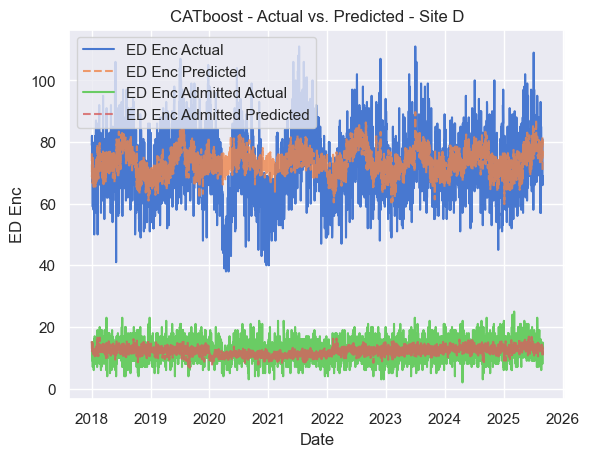

In [69]:
plot_df = siteD_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = siteD_catmodel.predict(siteD_real_X.to_pandas())
predict_df = siteD_real_X.with_columns(
    pl.Series(name="ED Enc Predicted", values=predict[:,0]),
    pl.Series(name="ED Enc Admitted Predicted", values=predict[:,1])
).with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc Predicted").sum(), pl.col("ED Enc Admitted Predicted").sum())

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)
sns.lineplot(data=plot_df, x="Date", y="ED Enc Admitted", label="ED Enc Admitted Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Admitted Predicted", label="ED Enc Admitted Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("CATboost - Actual vs. Predicted - Site D")
plt.show()

# ARIMA model
A popular model in forecasting time series data

In [ ]:
daily_pandas_df = df.group_by(["Site", "Date"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum()).to_pandas().set_index("Date")
daily_pandas_df

,Site,ED Enc,ED Enc Admitted
Date,,,
2021-05-27,A,98,25
2022-09-24,A,111,32
2024-10-05,B,185,44
2024-11-16,B,177,47
2022-01-08,C,95,25
...,...,...,...
2025-02-27,D,85,12
2025-05-06,D,80,13
2025-07-05,D,91,11


In [ ]:
import pmdarima as pm

siteA_data = daily_pandas_df.loc[daily_pandas_df["Site"] == "A"].drop("Site", axis=1)
model = pm.auto_arima(siteA_data["ED Enc"], seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=inf, Time=6.32 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=23196.541, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=22983.378, Time=1.56 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=23041.508, Time=0.89 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=34861.795, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=22984.675, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=22985.168, Time=8.49 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=22991.509, Time=3.20 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=22982.275, Time=0.41 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=22983.653, Time=1.50 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=inf, Time=7.97 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=23183.343, Time=0.43 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=22874.474, Time=0.74 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=22875.125, Time=0.16 sec
 ARIMA(2,0,0)(1,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2800
Model:               SARIMAX(5, 0, 0)   Log Likelihood              -11415.671
Date:                Wed, 04 Feb 2026   AIC                          22845.343
Time:                        09:19:21   BIC                          22886.904
Sample:                             0   HQIC                         22860.345
                               - 2800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     58.6129      3.470     16.892      0.000      51.812      65.414
ar.L1          0.1920      0.017     10.982      0.000       0.158       0.226
ar.L2          0.1656      0.019      8.735      0.000       0.128       0.203
ar.L3          0.0747      0.019      3.887      0.000       0.037       0.112
ar.L4          0.0495      0.019      2.603      0.009       0.012       0.087
ar.L5          0.0350      0.019      1.886      0.059      -0.001       0.071
sigma2       203.6140      5.108     39.859      0.000     193.602     213.626
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.47
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                            -0.06
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from pmdarima import model_selection

model_cv_scores = model_selection.cross_val_score(
    model, siteA_data["ED Enc"], scoring="mean_squared_error"
)

print(f"Model CV Scores: {model_cv_scores.tolist()}")
print(f"Average mean squared error: {model_cv_scores.mean()}")

c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

Model CV Scores: [12.381072900706451, 1593.6335493542767, 42.07681510292549, 61.50954856376501, 3.5460669540914043, 190.65928665443187, 14.570881124229997, 266.9621087564909, 145.47809313549922, 45.531759734869325, 44.39220576192487, 0.7923288174112136, 155.82403913809367, 0.050704548644527746, 58.69157174324184, 14.778093082937305, 1089.3961740316518, 2.286422412665394, 93.21886069278625, 554.0815633760129, 229.5365601995421, 94.2882720951391, 141.62879719306773, 556.0197299067136, 365.9089552997664, 22.577596591977816, 134.94011114125337, 158.34465299844646, 11.129003134134967, 91.47116028559084, 43.12422145414183, 60.339865423266765, 837.0261320130196, 86.02062393762967, 552.754703396445, 36.51067297773321, 421.2434754925878, 108.91533829482577, 19.780361649632553, 233.99931468455608, 261.03258955720247, 28.56816954600427, 84.1621992360862, 744.2327192019796, 128.42074334093064, 104.90886787613185, 24.604363164915753, 649.4359846290592, 77.57768865419816, 121.15872980295144, 756.363

c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
date_range = pl.date_range(start=df["Date"].min(), end=df["Date"].max(), eager=True)

c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tammy\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


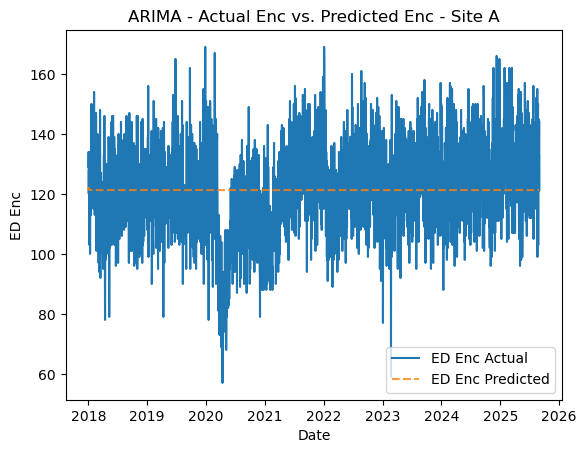

In [ ]:
plot_df = siteA_real.with_columns(
    pl.datetime(
        pl.col("Year"),
        pl.col("Month"),
        pl.col("Day"),
    ).alias("Date")
).group_by("Date").agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

predict = model.predict(n_periods=len(date_range))
predict_df = pl.DataFrame([date_range.alias("Date")]).with_columns(
    pl.Series(name="ED Enc Predicted", values=predict.tolist()),
    pl.Series(name="ED Enc Admitted Predicted", values=predict.tolist())
)

sns.lineplot(data=plot_df, x="Date", y="ED Enc", label="ED Enc Actual")
ax = sns.lineplot(data=predict_df, x="Date", y="ED Enc Predicted", label="ED Enc Predicted", linestyle="--", alpha=0.8)

ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_title("ARIMA - Actual Enc vs. Predicted Enc - Site A")
plt.show()